# Imports


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
#import squarify
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from collections import defaultdict

# Load Dataset

In [2]:
# # Install dependencies if needed:
# # pip install kagglehub[pandas-datasets]

# import kagglehub
# from kagglehub import KaggleDatasetAdapter
# import pandas as pd

# # Specify the CSV file you want from the dataset
# file_path = "2019-Oct.csv"  # You can change to another file, like '2019-Nov.csv'

# # Load only the first 1,000,000 rows using pandas_kwargs
# df = kagglehub.load_dataset(
#     KaggleDatasetAdapter.PANDAS,
#     "mkechinov/ecommerce-behavior-data-from-multi-category-store",
#     file_path,
#     pandas_kwargs={"nrows": 2000000}
# )

# # Show the first 5 records
# print("First 5 records:")
# print(df.head())


In [2]:
file_path = 'D:\\uni stuff\\Data Science\\Project\\2019-Oct.csv'
target_col = 'event_type'
sample_size = 1_000_000

In [3]:
# Step 1: Count the total number of rows (excluding header)
with open(file_path, 'r', encoding='utf-8') as f:
    n_rows = sum(1 for line in f) - 1  # minus 1 for header

In [4]:
# Step 2: Load only the 'event_type' column to get class distribution
event_types = pd.read_csv(file_path, usecols=[target_col])[target_col]

In [9]:
# Step 3: Get indices for each class
indices_per_class = defaultdict(list)
for idx, label in enumerate(event_types):
    indices_per_class[label].append(idx)

In [10]:
# Step 4: Calculate how many samples per class
num_classes = len(indices_per_class)
samples_per_class = sample_size // num_classes

In [11]:
# Step 5: Randomly sample indices for each class
balanced_indices = []
for label, indices in indices_per_class.items():
    if len(indices) < samples_per_class:
        raise ValueError(f"Not enough samples for class '{label}'")
    balanced_indices.extend(random.sample(indices, samples_per_class))

In [12]:
# Step 6: Prepare skip set (fast)
all_indices = set(range(1, n_rows + 1))  # line numbers excluding header
keep_indices = set(i + 1 for i in balanced_indices)  # shift by 1 for header
skip_set = all_indices - keep_indices

In [13]:
# Step 7: Read only sampled rows
df_balanced = pd.read_csv(file_path, skiprows=lambda x: x in skip_set)

In [14]:
# Step 8: Confirm class balance
print(df_balanced[target_col].value_counts())

event_type
purchase    333333
view        333333
cart        333333
Name: count, dtype: int64


In [15]:
df = df_balanced

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     999999 non-null  object 
 1   event_type     999999 non-null  object 
 2   product_id     999999 non-null  int64  
 3   category_id    999999 non-null  int64  
 4   category_code  776074 non-null  object 
 5   brand          917290 non-null  object 
 6   price          999999 non-null  float64
 7   user_id        999999 non-null  int64  
 8   user_session   999999 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 68.7+ MB


In [17]:
df.shape

(999999, 9)

# Preprocessing


In [18]:
df.isnull().sum().sum()

306634

In [19]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
1,2019-10-01 00:06:39 UTC,view,26204062,2053013563693335403,NaN,NaN,244.28,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc
2,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
3,2019-10-01 00:09:28 UTC,view,1307240,2053013558920217191,computers.notebook,asus,385.82,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3
4,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238


In [20]:
df.duplicated().sum()

5319

In [21]:
print(df['event_type'].value_counts())
print(df['event_type'].nunique())
df['event_type'].unique().tolist()

event_type
purchase    333333
view        333333
cart        333333
Name: count, dtype: int64
3


['purchase', 'view', 'cart']

In [22]:
print(df['event_type'].isnull().sum())

0


In [26]:
le = LabelEncoder()
df['event_type'] = le.fit_transform(df['event_type'])
print(le.classes_)

['cart' 'purchase' 'view']


In [27]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:04:37 UTC,1,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
1,2019-10-01 00:06:39 UTC,2,26204062,2053013563693335403,NaN,NaN,244.28,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc
2,2019-10-01 00:09:26 UTC,1,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
3,2019-10-01 00:09:28 UTC,2,1307240,2053013558920217191,computers.notebook,asus,385.82,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3
4,2019-10-01 00:09:33 UTC,0,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238


In [28]:
print(df['brand'].value_counts())
print(df['brand'].nunique())
print("___")
print(df['category_code'].value_counts())
print(df['category_code'].nunique())

brand
samsung     225258
apple       170414
xiaomi       87325
huawei       34034
oppo         16048
             ...  
labo             1
hada             1
insight          1
fidan            1
merkurij         1
Name: count, Length: 2450, dtype: int64
2450
___
category_code
electronics.smartphone          435860
electronics.audio.headphone      40587
electronics.video.tv             31512
electronics.clocks               25860
appliances.kitchen.washer        22057
                                 ...  
apparel.jacket                       6
apparel.shoes.espadrilles            5
construction.tools.soldering         3
auto.accessories.anti_freeze         2
country_yard.furniture.bench         1
Name: count, Length: 126, dtype: int64
126


In [29]:
df.brand.isnull().sum()

82709

In [30]:
df['category_code'] = df['category_code'].fillna(df['category_code'].mode()[0])
df.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code        0
brand            82709
price                0
user_id              0
user_session         0
dtype: int64

In [31]:
encoder = ce.BinaryEncoder(cols=['category_code'])
df_encoded = encoder.fit_transform(df[['category_code']])
df = pd.concat([df, df_encoded], axis=1)
print(df.head())

                event_time  event_type  product_id          category_id  \
0  2019-10-01 00:04:37 UTC           1     1002532  2053013555631882655   
1  2019-10-01 00:06:39 UTC           2    26204062  2053013563693335403   
2  2019-10-01 00:09:26 UTC           1     4804055  2053013554658804075   
3  2019-10-01 00:09:28 UTC           2     1307240  2053013558920217191   
4  2019-10-01 00:09:33 UTC           0     1002524  2053013555631882655   

                 category_code  brand   price    user_id  \
0       electronics.smartphone  apple  642.69  551377651   
1       electronics.smartphone    NaN  244.28  515547943   
2  electronics.audio.headphone  apple  189.91  524601178   
3           computers.notebook   asus  385.82  520575653   
4       electronics.smartphone  apple  515.67  524325294   

                           user_session  category_code_0  category_code_1  \
0  3c80f0d6-e9ec-4181-8c5c-837a30be2d68                0                0   
1  4737b7aa-83f7-4899-86e0-2d53b2d

In [32]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_0,category_code_1,category_code_2,category_code_3,category_code_4,category_code_5,category_code_6
0,2019-10-01 00:04:37 UTC,1,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,0,0,0,0,1
1,2019-10-01 00:06:39 UTC,2,26204062,2053013563693335403,electronics.smartphone,NaN,244.28,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,0,0,0,0,0,1
2,2019-10-01 00:09:26 UTC,1,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,0,0,0,1,0
3,2019-10-01 00:09:28 UTC,2,1307240,2053013558920217191,computers.notebook,asus,385.82,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,0,0,0,0,1,1
4,2019-10-01 00:09:33 UTC,0,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,0,0,0,0,0,1


In [33]:
df['brand'] = df['brand'].fillna(df['brand'].mode()[0])
df.isnull().sum()

event_time         0
event_type         0
product_id         0
category_id        0
category_code      0
brand              0
price              0
user_id            0
user_session       0
category_code_0    0
category_code_1    0
category_code_2    0
category_code_3    0
category_code_4    0
category_code_5    0
category_code_6    0
dtype: int64

In [34]:
encoder = ce.BinaryEncoder(cols=['brand'])
df_encoded = encoder.fit_transform(df['brand'])
df = pd.concat([df, df_encoded], axis=1)

In [35]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category_code_0,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:04:37 UTC,1,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:06:39 UTC,2,26204062,2053013563693335403,electronics.smartphone,samsung,244.28,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:09:26 UTC,1,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,...,0,0,0,0,0,0,0,0,0,1
3,2019-10-01 00:09:28 UTC,2,1307240,2053013558920217191,computers.notebook,asus,385.82,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,...,0,0,0,0,0,0,0,0,1,1
4,2019-10-01 00:09:33 UTC,0,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
df = df.drop(['category_code', 'brand'], axis=1)

In [37]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:04:37 UTC,1,1002532,2053013555631882655,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:06:39 UTC,2,26204062,2053013563693335403,244.28,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:09:26 UTC,1,4804055,2053013554658804075,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2019-10-01 00:09:28 UTC,2,1307240,2053013558920217191,385.82,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,2019-10-01 00:09:33 UTC,0,1002524,2053013555631882655,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

if not outliers.empty:
  print("Outliers found in the 'price' column:")
  print(outliers[['price']])
else:
  print("No outliers found in the 'price' column based on the IQR method.")

Outliers found in the 'price' column:
          price
17       809.72
20       946.97
25       809.72
26      1328.22
29      1747.79
...         ...
999967  1158.07
999969  1055.34
999980   928.38
999991  1889.07
999996  1054.60

[93916 rows x 1 columns]


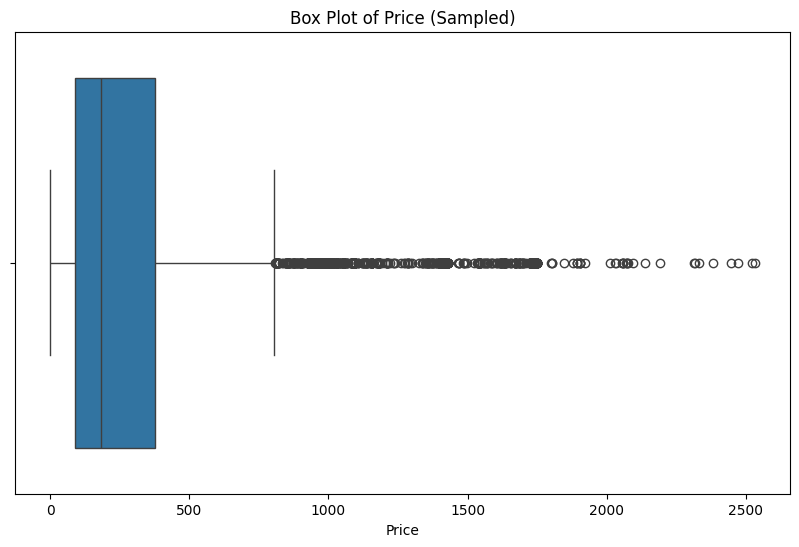

In [39]:
# Sample 10,000 rows from the dataset
sample_df = df['price'].sample(n=10000, random_state=42)

plt.figure(figsize=(10, 6))
sns.boxplot(x=sample_df)
plt.title('Box Plot of Price (Sampled)')
plt.xlabel('Price')
plt.show()

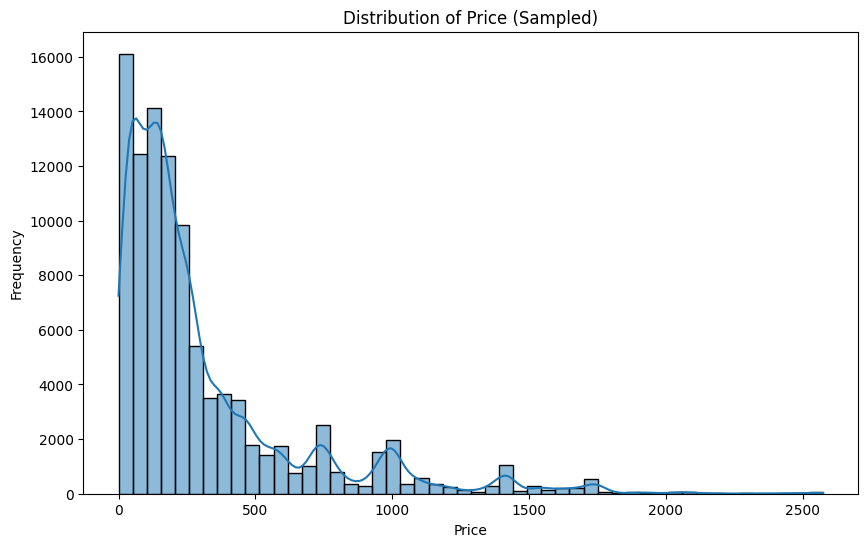

In [40]:
# Sample 100,000 rows (adjust size based on available memory)
sample = df['price'].sample(n=100000, random_state=42)

plt.figure(figsize=(10, 6))
sns.histplot(sample, kde=True, bins=50)
plt.title('Distribution of Price (Sampled)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

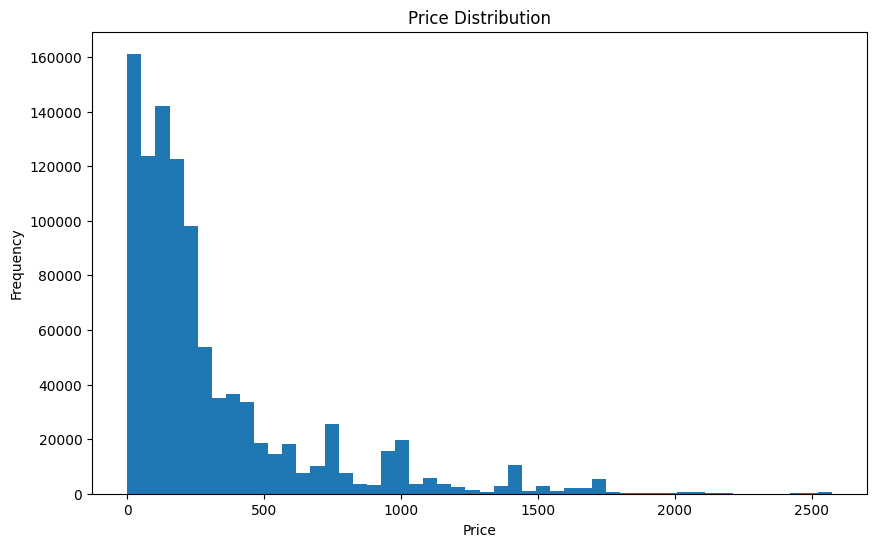

In [41]:
import numpy as np

counts, bins = np.histogram(df['price'].dropna(), bins=50)
plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['price'] = scaler.fit_transform(df[['price']])

print(df['price'].head())

0    0.937399
1   -0.188667
2   -0.342339
3    0.211381
4    0.578390
Name: price, dtype: float64


In [43]:
df.head()

,event_time,event_type,product_id,category_id,price,user_id,user_session,category_code_0,category_code_1,category_code_2,...,brand_2,brand_3,brand_4,brand_5,brand_6,brand_7,brand_8,brand_9,brand_10,brand_11
0,2019-10-01 00:04:37 UTC,1,1002532,2053013555631882655,0.937399,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2019-10-01 00:06:39 UTC,2,26204062,2053013563693335403,-0.188667,515547943,4737b7aa-83f7-4899-86e0-2d53b2ddbffc,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019-10-01 00:09:26 UTC,1,4804055,2053013554658804075,-0.342339,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2019-10-01 00:09:28 UTC,2,1307240,2053013558920217191,0.211381,520575653,9acd3cb7-79b7-4293-bb81-bec02a1c9cd3,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,2019-10-01 00:09:33 UTC,0,1002524,2053013555631882655,0.578390,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   event_time       999999 non-null  object 
 1   event_type       999999 non-null  int32  
 2   product_id       999999 non-null  int64  
 3   category_id      999999 non-null  int64  
 4   price            999999 non-null  float64
 5   user_id          999999 non-null  int64  
 6   user_session     999999 non-null  object 
 7   category_code_0  999999 non-null  int64  
 8   category_code_1  999999 non-null  int64  
 9   category_code_2  999999 non-null  int64  
 10  category_code_3  999999 non-null  int64  
 11  category_code_4  999999 non-null  int64  
 12  category_code_5  999999 non-null  int64  
 13  category_code_6  999999 non-null  int64  
 14  brand_0          999999 non-null  int64  
 15  brand_1          999999 non-null  int64  
 16  brand_2          999999 non-null  int6

In [45]:
df.shape

(999999, 26)

In [46]:
df['event_time'] = pd.to_datetime(df['event_time'], utc=True)

In [47]:
df['event_time']

0        2019-10-01 00:04:37+00:00
1        2019-10-01 00:06:39+00:00
2        2019-10-01 00:09:26+00:00
3        2019-10-01 00:09:28+00:00
4        2019-10-01 00:09:33+00:00
                    ...           
999994   2019-10-31 23:56:03+00:00
999995   2019-10-31 23:56:07+00:00
999996   2019-10-31 23:56:53+00:00
999997   2019-10-31 23:58:19+00:00
999998   2019-10-31 23:59:16+00:00
Name: event_time, Length: 999999, dtype: datetime64[ns, UTC]

In [48]:
df.dtypes

event_time         datetime64[ns, UTC]
event_type                       int32
product_id                       int64
category_id                      int64
price                          float64
user_id                          int64
user_session                    object
category_code_0                  int64
category_code_1                  int64
category_code_2                  int64
category_code_3                  int64
category_code_4                  int64
category_code_5                  int64
category_code_6                  int64
brand_0                          int64
brand_1                          int64
brand_2                          int64
brand_3                          int64
brand_4                          int64
brand_5                          int64
brand_6                          int64
brand_7                          int64
brand_8                          int64
brand_9                          int64
brand_10                         int64
brand_11                 

In [49]:
df.set_index('event_time', inplace=True)

In [54]:
print(df.columns)

Index(['event_type', 'product_id', 'category_id', 'price', 'user_id',
       'user_session', 'category_code_0', 'category_code_1', 'category_code_2',
       'category_code_3', 'category_code_4', 'category_code_5',
       'category_code_6', 'brand_0', 'brand_1', 'brand_2', 'brand_3',
       'brand_4', 'brand_5', 'brand_6', 'brand_7', 'brand_8', 'brand_9',
       'brand_10', 'brand_11'],
      dtype='object')


In [55]:
daily_events = df.resample('D').size()

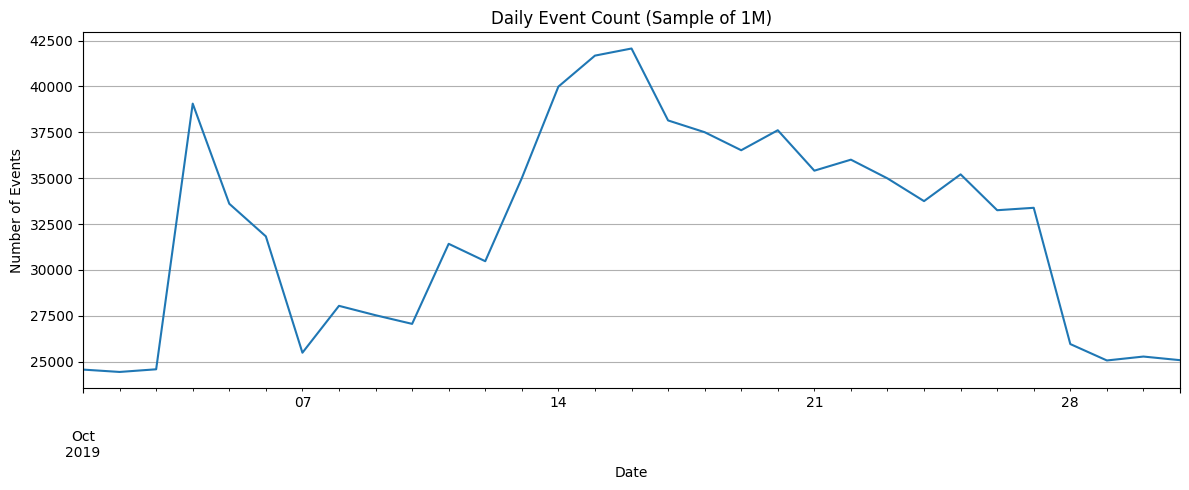

In [56]:
# Plot the result
plt.figure(figsize=(12, 5))
daily_events.plot(title='Daily Event Count (Sample of 1M)')
plt.ylabel('Number of Events')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

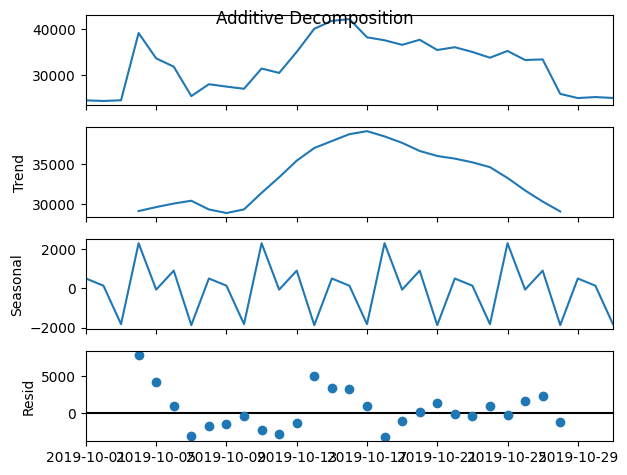

In [57]:
# Additive decomposition
result_add = seasonal_decompose(daily_events, model='additive', period=7)  # period=7 for weekly seasonality
result_add.plot()
plt.suptitle('Additive Decomposition')
plt.show()

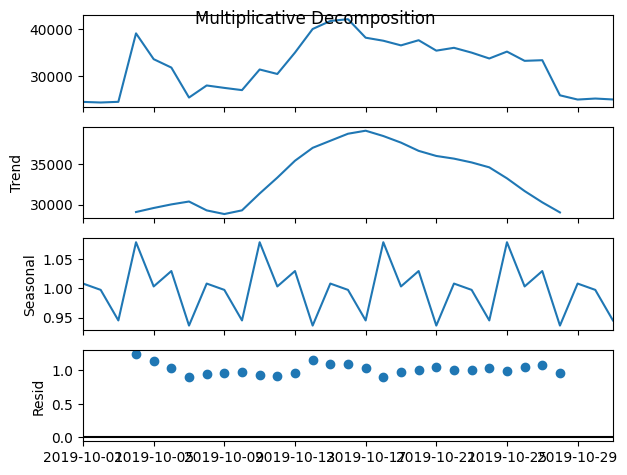

In [58]:
# Multiplicative decomposition
result_mul = seasonal_decompose(daily_events, model='multiplicative', period=7)
result_mul.plot()
plt.suptitle('Multiplicative Decomposition')
plt.show()

In [59]:
# Aggregate: count number of events per day
daily_events = df.groupby(df.index.date).size()
daily_events = daily_events.rename('event_count').to_frame()

In [60]:
# Perform ADF test on this daily event count series
result = adfuller(daily_events['event_count'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Critical values for significance levels
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

if result[1] < 0.05:
    print('The series is stationary')
else:
    print('The series is not stationary')

ADF Statistic: -2.367314
p-value: 0.151175
Critical Value 1%: -3.6889256286443146
Critical Value 5%: -2.9719894897959187
Critical Value 10%: -2.6252957653061224
The series is not stationary


In [61]:
result_mul.trend.index = result_mul.trend.index.tz_localize(None)
detrended = daily_events['event_count'] / result_mul.trend

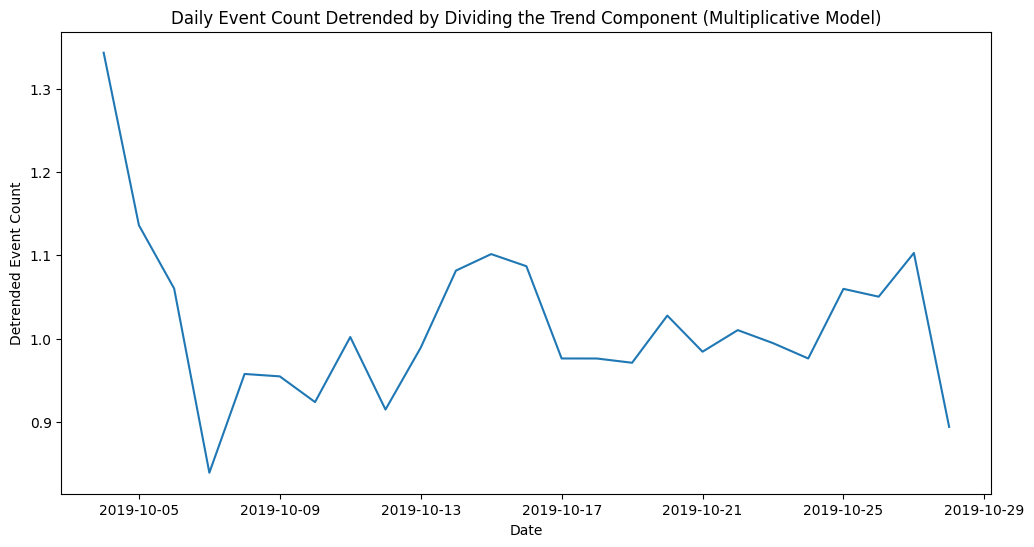

In [62]:
plt.figure(figsize=(12,6))
plt.plot(detrended)
plt.title('Daily Event Count Detrended by Dividing the Trend Component (Multiplicative Model)')
plt.xlabel('Date')
plt.ylabel('Detrended Event Count')
plt.show()

In [63]:
result_mul_seasonal = result_mul.seasonal.copy()
result_mul_seasonal.index = result_mul_seasonal.index.tz_localize(None)  # remove tz info

In [64]:
seasonally_adjusted = detrended / result_mul_seasonal

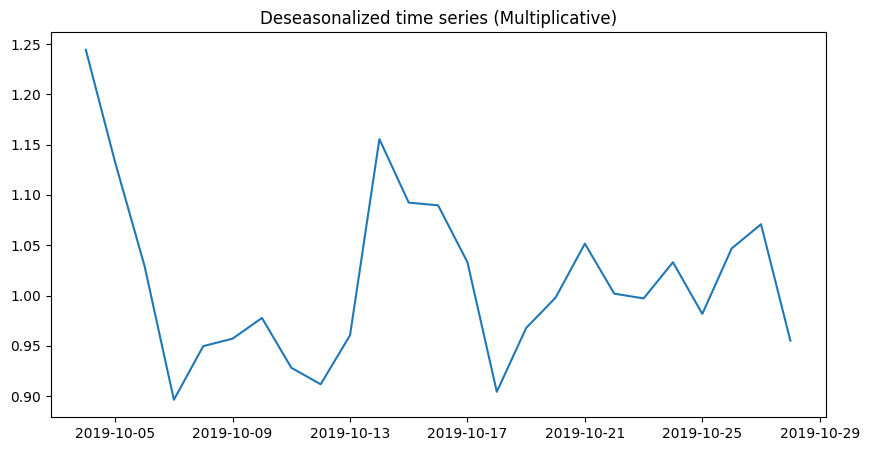

In [65]:
plt.figure(figsize=(10,5))
plt.plot(seasonally_adjusted)
plt.title('Deseasonalized time series (Multiplicative)')
plt.show()

In [66]:
result = adfuller(seasonally_adjusted.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print('The deseasonalized series is stationary')
else:
    print('The deseasonalized series is not stationary')

ADF Statistic: -6.492346
p-value: 0.000000
The deseasonalized series is stationary


In [67]:
# Interpolate missing values in the deseasonalized series
seasonally_adjusted_filled = seasonally_adjusted.interpolate(method='linear')

# Double-check if any missing values remain
print(seasonally_adjusted_filled.isnull().sum())

3


In [68]:
seasonally_adjusted_filled = seasonally_adjusted_filled.dropna()
print(seasonally_adjusted_filled.isnull().sum())  # 0 now

0


In [69]:
print(len(seasonally_adjusted_filled))

28


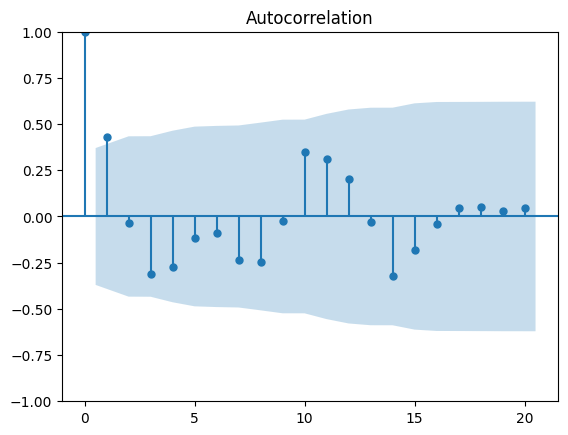

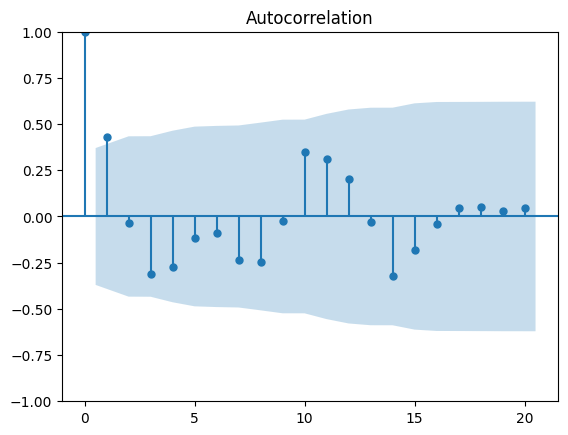

In [70]:
plot_acf(seasonally_adjusted_filled.dropna(), lags=20, ax=plt.gca())

C:\Users\yahia\AppData\Local\Temp\ipykernel_36028\99664390.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


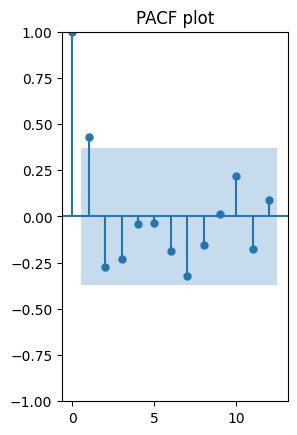

In [71]:
lags = 12  # less than 28/2
plot_acf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('ACF plot')

plt.subplot(1,2,2)
plot_pacf(seasonally_adjusted_filled.dropna(), lags=lags, ax=plt.gca())
plt.title('PACF plot')
plt.show()

In [73]:
df['event_type'].unique()

array([1, 2, 0])

In [74]:
# Save DataFrame to CSV
df.to_csv('Preprocessed Time Series Final.csv', index=False)